In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
import matplotlib

import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely import affinity

from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
import astropy.units as u

import sys

In [2]:
folder = 'C:/Users/oryan/Documents/PySPAM_Original_Python_MCMC'

In [3]:
image = np.load('C:/Users/oryan/Documents/PySPAM_Original_Python_MCMC/APySPAM_MCMC/All_Inputs/Arp294.npy')

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


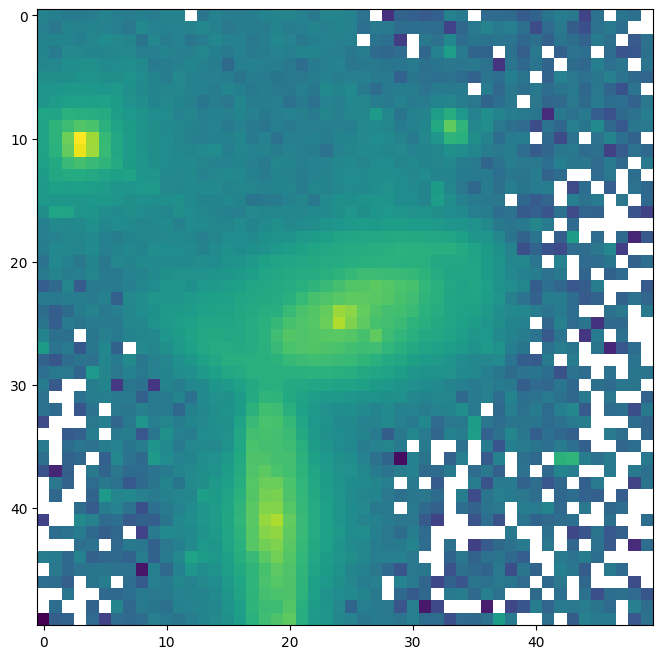

In [4]:
plt.figure(figsize=(12,8))
plt.imshow(np.log10(image))
plt.show()

### Getting Galactic Centres

In [5]:
galaxy = 'Arp294'

In [6]:
redshifts = pd.read_csv(f'{folder}/APySPAM_MCMC/Redshifts/Redshifts.csv', index_col = 0)

In [7]:
coordinates = pd.read_csv(f'{folder}/APySPAM_MCMC/data/all_coords.csv', index_col = 0).query('Names == @galaxy')

In [8]:
block_reduce = redshifts.query('Names == @galaxy').block_reduce.iloc[0]
z = redshifts.query('Names == @galaxy').Redshift.iloc[0]

In [9]:
prim_coords = SkyCoord(
    ra = coordinates.Prim_RA.iloc[0] * u.deg,
    dec = coordinates.Prim_DEC.iloc[0] * u.deg,
    frame = 'fk5'
)

In [10]:
sec_coords = SkyCoord(
    ra = coordinates.Sec_RA.iloc[0] * u.deg,
    dec = coordinates.Sec_DEC.iloc[0] * u.deg,
    frame = 'fk5'
)

In [11]:
dra, ddec = prim_coords.spherical_offsets_to(sec_coords)

dra_m = dra.to(u.arcmin)
ddec_m = ddec.to(u.arcmin)

cosmo = FlatLambdaCDM(H0=67.8 * u.km / u.s / u.Mpc, Tcmb0=2.275 * u.K, Om0 = 0.308)

conversion = cosmo.kpc_proper_per_arcmin(z)

phys_x = conversion * dra_m
phys_y = conversion * ddec_m

sim_x = float(phys_x / (15 * u.kpc))
sim_y = float(phys_y / (15 * u.kpc))

In [12]:
pix_res = float((0.396 * u.arcsec)  * conversion.to(u.kpc / u.arcsec) * block_reduce / (15 * u.kpc))

In [13]:
pixel_x = int(25 - (sim_x / pix_res))
pixel_y = int(25 + (sim_y / pix_res))

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


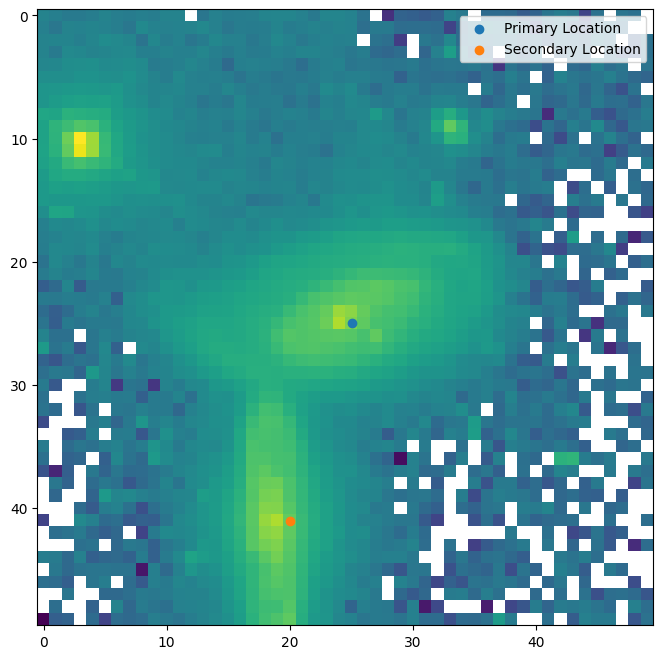

In [14]:
plt.figure(figsize=(12,8))
plt.imshow(np.log10(image))
plt.scatter(int(image.shape[0] / 2), int(image.shape[1] / 2), label = 'Primary Location')
plt.scatter(pixel_x, pixel_y, label = 'Secondary Location')
plt.legend()
plt.show()

### Removing Stars

In [15]:
n = 99.9
cut = np.percentile(image,n)
cut

4.745420670294113e-26

In [16]:
mask = image.copy()
mask[mask > cut] = True
mask[mask <= cut] = False
mask = np.ma.make_mask(mask)

In [17]:
image_masked = image.copy()
image_masked[mask] = 0

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


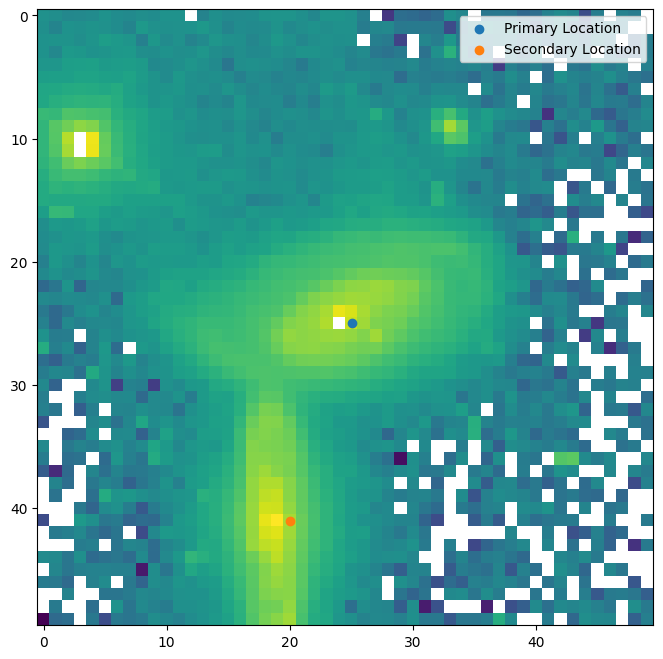

In [18]:
plt.figure(figsize=(12,8))
plt.imshow(np.log10(image_masked))
plt.scatter(int(image_masked.shape[0] / 2), int(image_masked.shape[1] / 2), label = 'Primary Location')
plt.scatter(pixel_x, pixel_y, label = 'Secondary Location')
plt.legend()
plt.show()

### Getting Cutouts

In [19]:
x_shape, y_shape = image.shape

In [20]:
prim_limits = [int(x_shape/2 - x_shape/5), int(x_shape/2 + x_shape/5), int(y_shape/2 - y_shape/5), int(y_shape/2 + y_shape/5)]

In [21]:
prim_cutout = image_masked[prim_limits[0]:prim_limits[1], prim_limits[2]:prim_limits[3]]

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


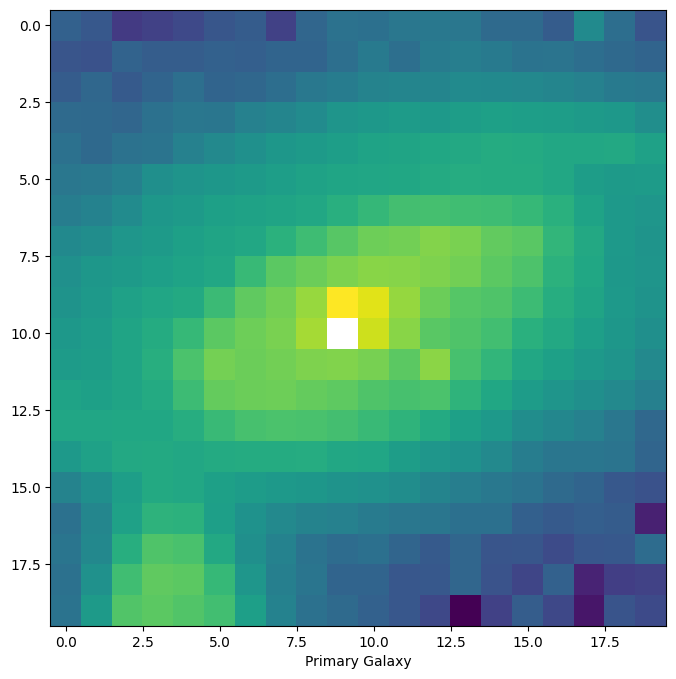

In [22]:
plt.figure(figsize = (12,8))
plt.imshow(np.log10(prim_cutout))
plt.xlabel('Primary Galaxy')
plt.show()

In [23]:
sec_limits = [int(pixel_x - x_shape/5), int(pixel_x + x_shape/5), int(pixel_y - y_shape/5), int(pixel_y + y_shape/5)]

In [24]:
for i in range(len(sec_limits)):
    if sec_limits[i] > 50:
        sec_limits[i] = 50
        continue
    if sec_limits[i] < 0:
        sec_limits[i] = 0
        continue

In [25]:
sec_cutout = image_masked[sec_limits[2]:sec_limits[3], sec_limits[0]:sec_limits[1]]

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


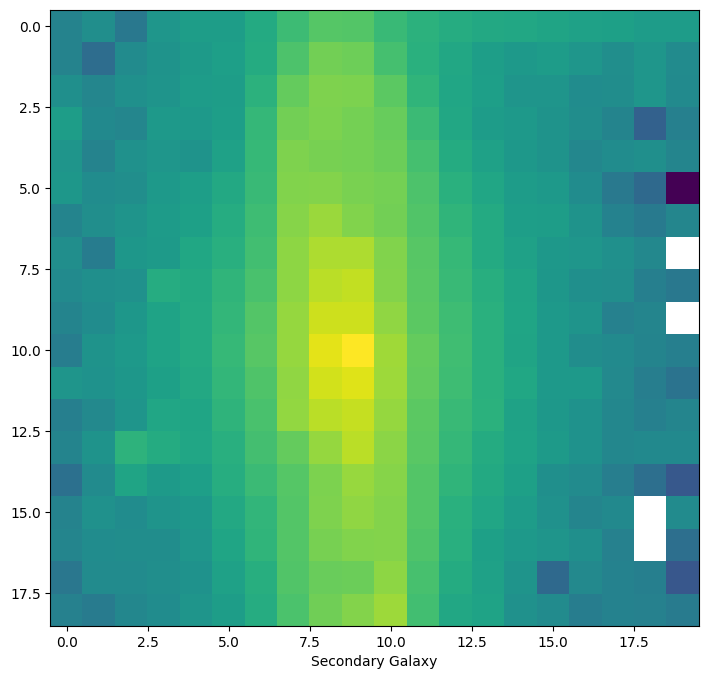

In [26]:
plt.figure(figsize = (12,8))
plt.imshow(np.log10(sec_cutout))
plt.xlabel('Secondary Galaxy')
plt.show()

### Converting to Binary

In [27]:
prim_cut = np.percentile(prim_cutout, 70)

In [28]:
prim_cutout_bin = prim_cutout.copy()
prim_cutout_bin[prim_cutout > prim_cut] = 1
prim_cutout_bin[prim_cutout <= prim_cut] = 0
prim_cutout_bin = prim_cutout_bin.astype('int')

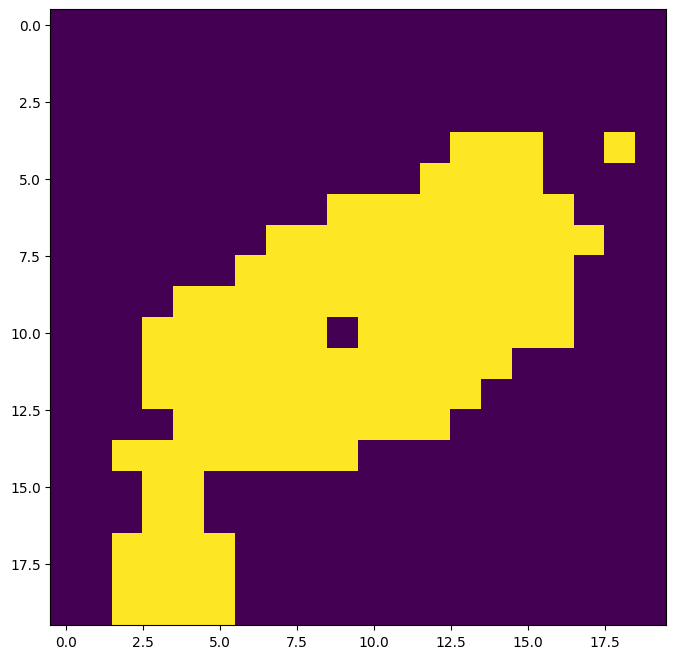

In [29]:
plt.figure(figsize = (12,8))
plt.imshow(prim_cutout_bin)
plt.show()

In [30]:
sec_cut = np.percentile(sec_cutout, 70)

In [31]:
sec_cutout_bin = sec_cutout.copy()
sec_cutout_bin[sec_cutout > sec_cut] = 1
sec_cutout_bin[sec_cutout <= sec_cut] = 0
sec_cutout_bin = sec_cutout_bin.astype('int')

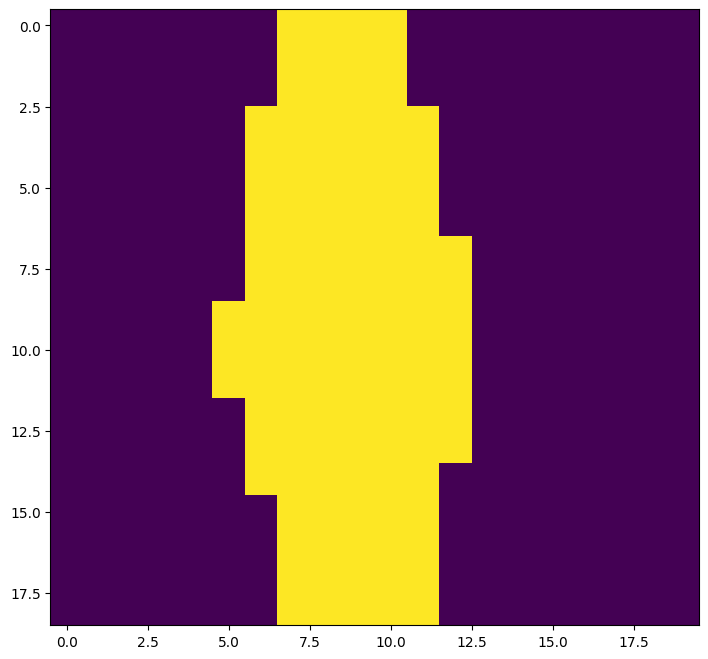

In [32]:
plt.figure(figsize = (12,8))
plt.imshow(sec_cutout_bin)
plt.show()

### Converting to Shapely Polygons

In [33]:
contours_prim, _ = cv.findContours(prim_cutout_bin, cv.RETR_FLOODFILL, cv.CHAIN_APPROX_NONE)
contours_sec, _ = cv.findContours(sec_cutout_bin, cv.RETR_FLOODFILL, cv.CHAIN_APPROX_NONE)

In [34]:
def getting_correct_contours(contours):
    length = 0
        
    for i in contours:
        if len(i) > length:
            correct_contours = i
            length = len(i)
    
    return correct_contours

In [35]:
prim_contour_nest_list = getting_correct_contours(contours_prim)
sec_contour_nest_list = getting_correct_contours(contours_sec)

In [36]:
def conts_to_list(contours):
    contour_list = []
    for i in range(len(contours)):
        row = contours[i][0]
        contour_list.append([row[0], row[1]])
    return contour_list

In [37]:
prim_contour_list = conts_to_list(prim_contour_nest_list)
sec_contour_list = conts_to_list(sec_contour_nest_list)

In [38]:
prim_poly = Polygon(prim_contour_list)
sec_poly = Polygon(sec_contour_list)

### Centering Polygon for Comparison

In [39]:
centre_prim = np.asarray(prim_poly.centroid.xy)
centre_sec = np.asarray(sec_poly.centroid.xy)

In [40]:
coords_array_prim = np.asarray(prim_contour_list)
coords_array_sec = np.asarray(sec_contour_list)

In [41]:
centred_coords_prim = coords_array_prim - centre_prim.T
centred_coords_sec = coords_array_sec - centre_sec.T

In [42]:
centred_prim_poly = Polygon(centred_coords_prim).buffer(0.0001)
centred_sec_poly = Polygon(centred_coords_sec).buffer(0.0001)

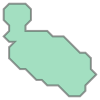

In [43]:
centred_prim_poly

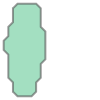

In [44]:
centred_sec_poly

If my Polygon is invalid, the last buffering step here can completely break the Polygon... I will need to look into a way to compensate for this. Upping the percentile seems to fix it quite well. Need a way to do this is I get a MultiPolygon out at the end!!

### Comparing with the Simulation Output

In [45]:
disk_image_path = 'C:\\Users\\oryan\\Documents\\PySPAM_Original_Python_MCMC\\notebooks\\images\\disk_image_1.npy'

In [46]:
disk_image = np.load(disk_image_path)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


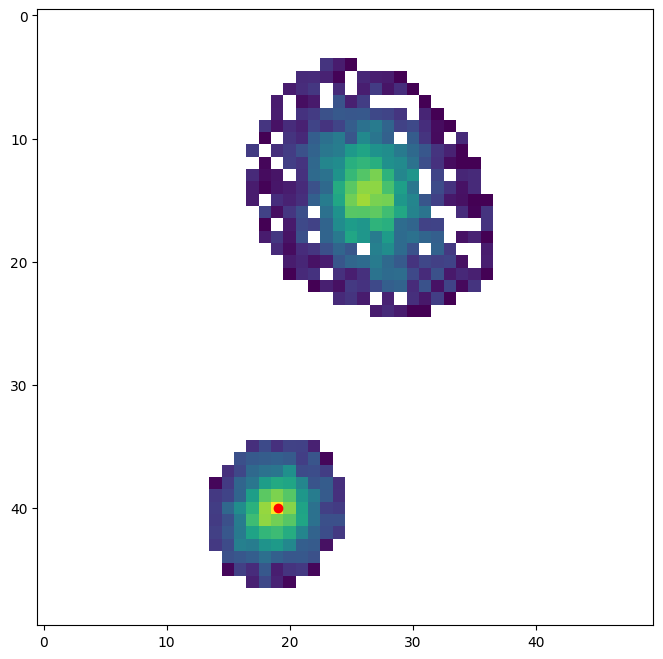

In [47]:
plt.figure(figsize = (12,8))
plt.imshow(np.log10(disk_image))
plt.scatter(19,40, color='r')
plt.show()

In [48]:
sim_prim_center = [27,15]
sim_sec_center = [19,40]

In [49]:
prim_sim_limits = [int(sim_prim_center[0] - x_shape/5), int(sim_prim_center[0] + x_shape/5), int(sim_prim_center[1] - y_shape/5), int(sim_prim_center[1] + y_shape/5)]
sec_sim_limits = [int(sim_sec_center[0] - x_shape/5), int(sim_sec_center[0] + x_shape/5), int(sim_sec_center[1] - y_shape/5), int(sim_sec_center[1] + y_shape/5)]

In [50]:
sim_prim_cutout_flux = disk_image[prim_sim_limits[2]:prim_sim_limits[3], prim_sim_limits[0]:prim_sim_limits[1]]
sim_sec_cutout_flux = disk_image[sec_sim_limits[2]:sec_sim_limits[3], sec_sim_limits[0]:sec_sim_limits[1]]

In [51]:
sim_prim_cutout = sim_prim_cutout_flux.copy()
sim_prim_cutout[sim_prim_cutout > 0] = 1
sim_prim_cutout[sim_prim_cutout == 0] = 0
sim_prim_cutout = sim_prim_cutout.astype('int')

In [52]:
sim_sec_cutout = sim_sec_cutout_flux.copy()
sim_sec_cutout[sim_sec_cutout > 0] = 1
sim_sec_cutout[sim_sec_cutout == 0] = 0
sim_sec_cutout = sim_sec_cutout.astype('int')

In [53]:
contours_prim, _ = cv.findContours(sim_prim_cutout, cv.RETR_FLOODFILL, cv.CHAIN_APPROX_NONE)
contours_sec, _ = cv.findContours(sim_sec_cutout, cv.RETR_FLOODFILL, cv.CHAIN_APPROX_NONE)

In [54]:
def getting_correct_contours(contours):
    length = 0
        
    for i in contours:
        if len(i) > length:
            correct_contours = i
            length = len(i)
    
    return correct_contours

In [55]:
prim_contour_nest_list = getting_correct_contours(contours_prim)
sec_contour_nest_list = getting_correct_contours(contours_sec)

In [56]:
def conts_to_list(contours):
    contour_list = []
    for i in range(len(contours)):
        row = contours[i][0]
        contour_list.append([row[0], row[1]])
    return contour_list

In [57]:
prim_contour_list = conts_to_list(prim_contour_nest_list)
sec_contour_list = conts_to_list(sec_contour_nest_list)

In [58]:
prim_poly = Polygon(prim_contour_list)
sec_poly = Polygon(sec_contour_list)

### Centering Polygon for Comparison

In [59]:
centre_prim = np.asarray(prim_poly.centroid.xy)
centre_sec = np.asarray(sec_poly.centroid.xy)

In [60]:
coords_array_prim = np.asarray(prim_contour_list)
coords_array_sec = np.asarray(sec_contour_list)

In [61]:
centred_coords_prim = coords_array_prim - centre_prim.T
centred_coords_sec = coords_array_sec - centre_sec.T

In [62]:
sim_centred_prim_poly = Polygon(centred_coords_prim).buffer(0.0001)
sim_centred_sec_poly = Polygon(centred_coords_sec).buffer(0.0001)

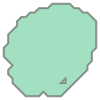

In [63]:
sim_centred_prim_poly

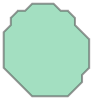

In [64]:
sim_centred_sec_poly

In [65]:
prim_intersection = centred_prim_poly.intersection(sim_centred_prim_poly).area
prim_union = unary_union([centred_prim_poly, sim_centred_prim_poly]).area
prim_jaccard_dist = 1 - (prim_intersection / prim_union)

sec_intersection = centred_sec_poly.intersection(sim_centred_sec_poly).area
sec_union = unary_union([centred_sec_poly, sim_centred_sec_poly]).area
sec_jaccard_dist = 1 - (sec_intersection / sec_union)

In [66]:
prim_jaccard_dist

0.6071492321832257

In [67]:
sec_jaccard_dist

0.4210617719828498

I now have the Jaccard Distance across this. But need to weight it by the internal flux.

### Applying Polygon to Galaxy

In [68]:
def summing_galaxy_flux(cutout, polygon):    
    # Centering Polygon in cutout
    cutout_centered_poly = Polygon(np.asarray(polygon.exterior.xy).T + np.asarray([cutout.shape[0]/2, cutout.shape[1]/2]))
    cutout_centered_sim_poly_arr = matplotlib.path.Path(np.asarray(cutout_centered_poly.exterior.xy).T.astype(int))
    
    # Creating Mesh to create masks
    x = np.arange(0,cutout.shape[0])
    y = np.arange(0,cutout.shape[1])
    
    xv, yv = np.meshgrid(x,y, indexing='xy')
    points = np.hstack((xv.reshape((-1,1)), yv.reshape((-1,1))))
    mask = cutout_centered_sim_poly_arr.contains_points(points)
    mask.shape = xv.shape    
    
    # Getting the Total Flux
    galaxy_flux = np.sum(cutout[mask.T])
    
    return galaxy_flux

In [69]:
prim_total_flux = summing_galaxy_flux(prim_cutout, centred_prim_poly)
sec_total_flux = summing_galaxy_flux(sec_cutout, centred_sec_poly)

sim_prim_total_flux = summing_galaxy_flux(sim_prim_cutout_flux, sim_centred_prim_poly)
sim_sec_total_flux = summing_galaxy_flux(sim_sec_cutout_flux, sim_centred_sec_poly)

In [74]:
prim_total_flux

4.050878484641106e-25

In [82]:
sim_prim_total_flux

7.079547199936704e-26

In [72]:
Chi_Squared = (( prim_total_flux / sim_prim_total_flux ) * prim_jaccard_dist) + (( sec_total_flux / sim_sec_total_flux ) * sec_jaccard_dist)

In [73]:
Chi_Squared

5.616994723105668